In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from src import camvid
from src import tiramisu
from src.utils import history_to_results

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
!mkdir -p models

In [3]:
mapping = pd.read_table('11_class.txt', sep=r'\s+', names=['og', 'new'], index_col='og').to_dict()['new']
_ = camvid.create_segmented_y(mapping=mapping)

##### Note

Because of the skip connections between the down-sampling and up-sampling sides of the network, input image size must be divisible by 32 (2^5). This is because of the max pooling / transpose convolution layers on the down-sampling and up-sampling branch of the network respectively. There are 5 of these units each with 2x2 kernel size and stride 2. Thus, the input must be divisible by 2^5 to ensure the outputs along the down-sampling side of the net can concatenate with the up-sampling side.

In [4]:
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the size to crop images to for fine tune training
fine_crop = (512, 640)
# fine_crop = (480, 640)

# Coarse Tuning

train on random crops of size 224 x 224 (images are also random flipped about x and y axis)

In [5]:
camvid11 = camvid.CamVid('y_11', crop_size=coarse_crop)
generators = camvid11.generators()

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


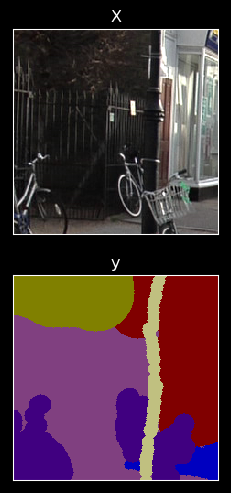

In [6]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [7]:
# build the model for the image shape and number of labels
model = tiramisu.build_tiramisu((*coarse_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
    learning_rate=1e-3,
)

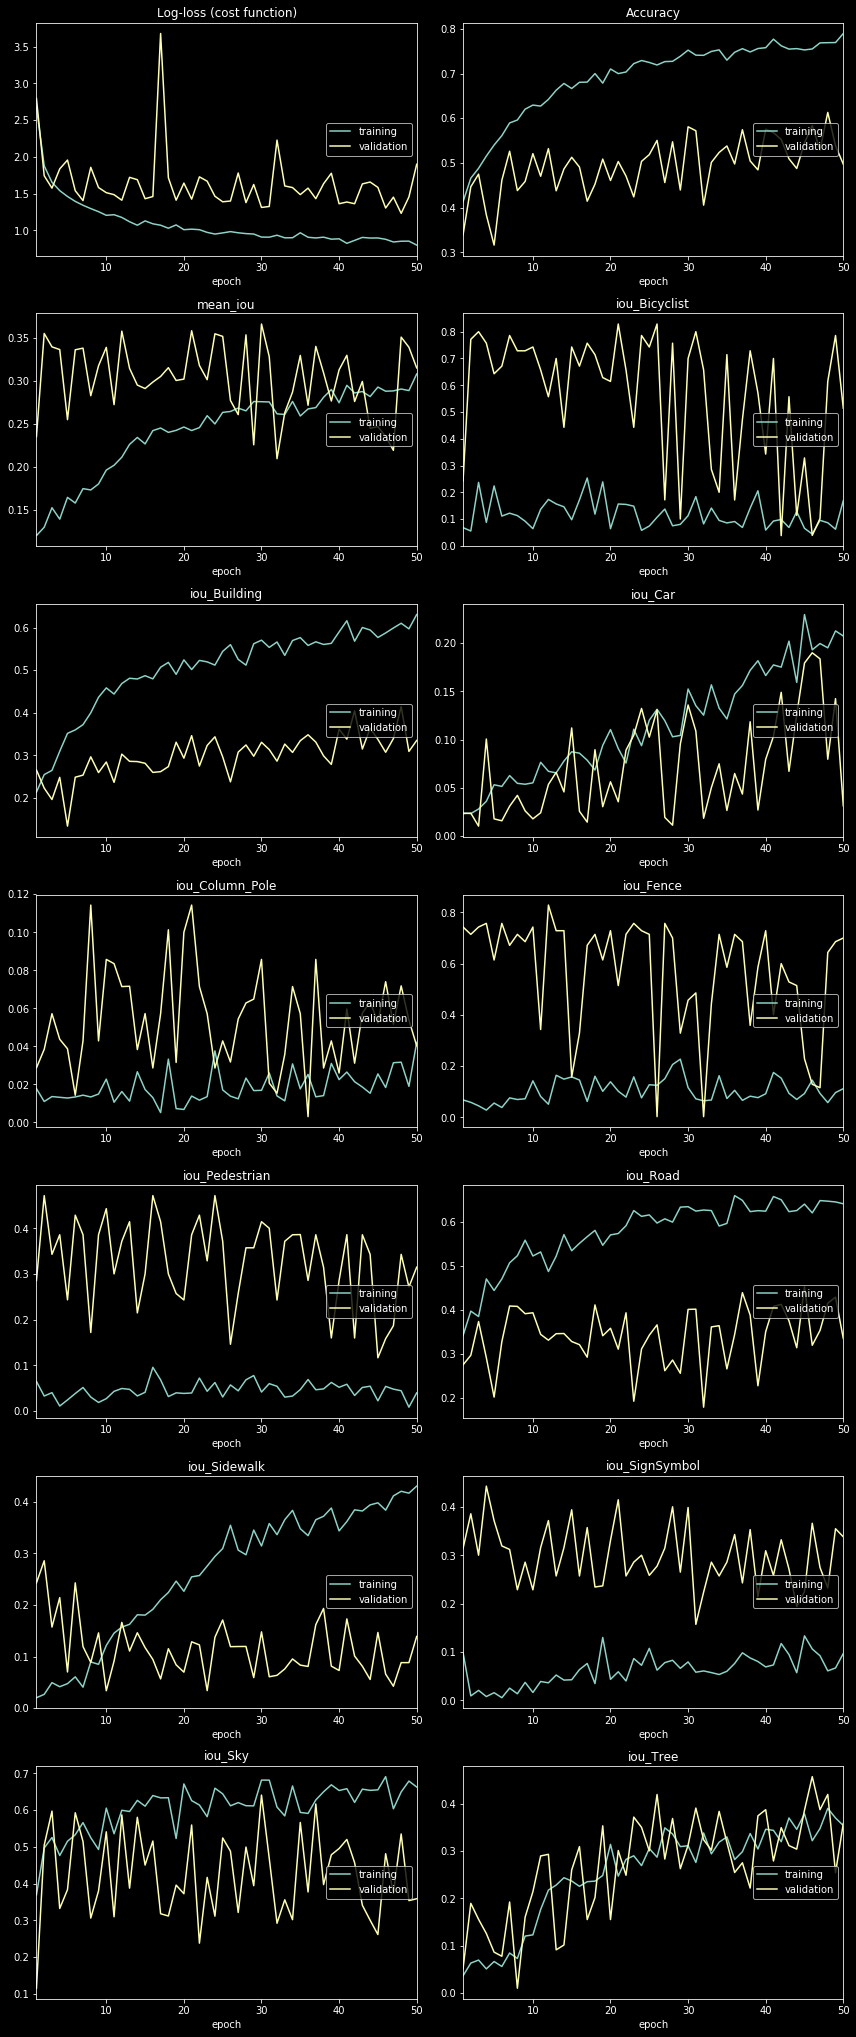

In [8]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['training'],
    epochs=50,
    steps_per_epoch=int(491 / 3),
    validation_data=generators['validation'],
    validation_steps=int(210 / 3),
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=100),
        PlotLossesKeras(),
    ],
    verbose=0
)

In [9]:
history_to_results(history)

,train,val
acc,0.789530,0.497235
Bicyclist,0.169049,0.514286
Building,0.630532,0.335121
Car,0.207468,0.031137
Column_Pole,0.042033,0.040279
Fence,0.111949,0.700015
Pedestrian,0.039625,0.314737
Road,0.641228,0.334483
Sidewalk,0.430438,0.139008
SignSymbol,0.097003,0.338103


In [10]:
metrics = model.evaluate_generator(generators['validation'], steps=210)
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

,val
loss,1.922727
acc,0.477826
mean_iou,0.305962
iou_Bicyclist,0.519048
iou_Building,0.352027
iou_Car,0.027008
iou_Column_Pole,0.048300
iou_Fence,0.671429
iou_Pedestrian,0.352533
iou_Road,0.312958


In [11]:
X, y = next(generators['training'])
y = camvid11.unmap(y)
p = model.predict(X)
p = camvid11.unmap(p)

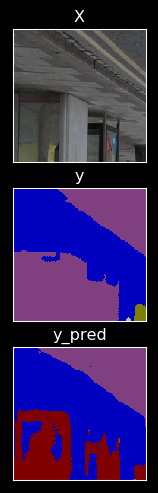

In [12]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

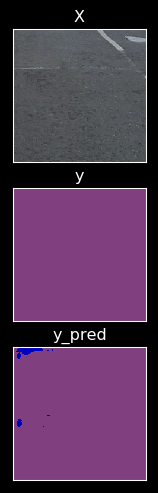

In [13]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

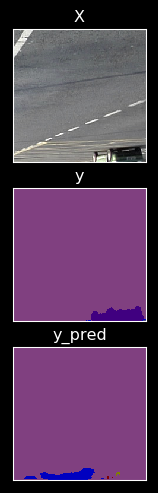

In [14]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

In [15]:
X, y = next(generators['validation'])
y = camvid11.unmap(y)
p = model.predict(X)
p = camvid11.unmap(p)

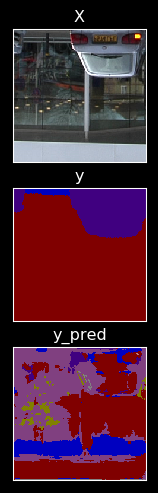

In [16]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

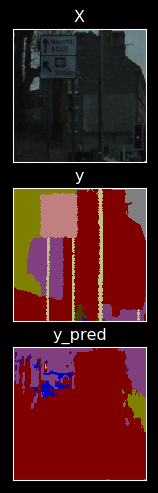

In [17]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

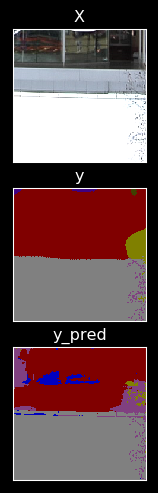

In [18]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

## Save Model

In [19]:
# serialize weights to HDF5
model.save_weights('models/Tiramisu103-CamVid11-coarse.h5')

# Clear Session

remove the current model from memory.

In [20]:
from keras import backend as K
K.clear_session()

# Fine Tuning

Train on larger crops (because the full size image results in a OutOfMemory error on the P100). max queue size of the fit generator is also reduced (resulting in a slowdown) to accomodate these larger images.

In [21]:
camvid11 = camvid.CamVid('y_11', crop_size=fine_crop, batch_size=1)
generators = camvid11.generators()

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


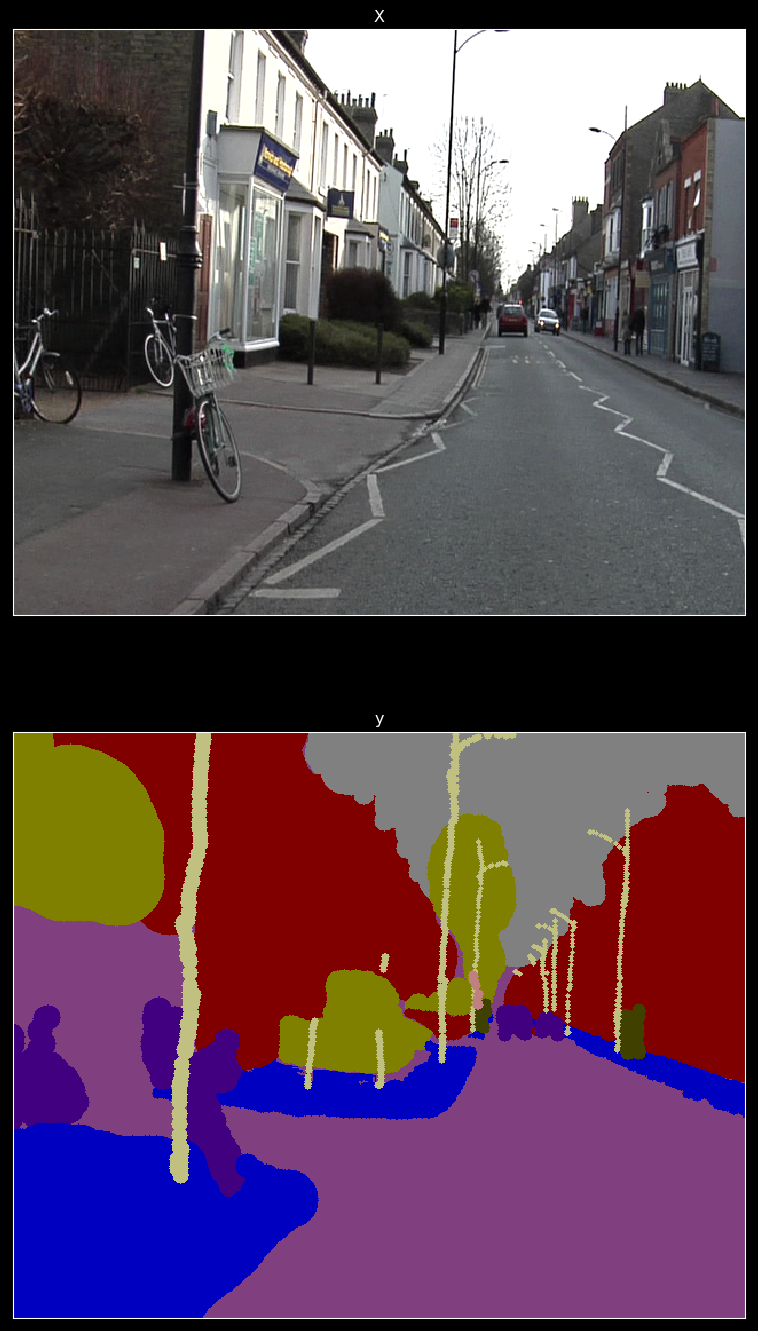

In [22]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [23]:
# build the model for the image shape and number of labels
tune_model = tiramisu.build_tiramisu((*fine_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
    learning_rate=1e-4,
)
# load the weights from the coarsely trained model
tune_model.load_weights('./models/Tiramisu103-CamVid11-coarse.h5')

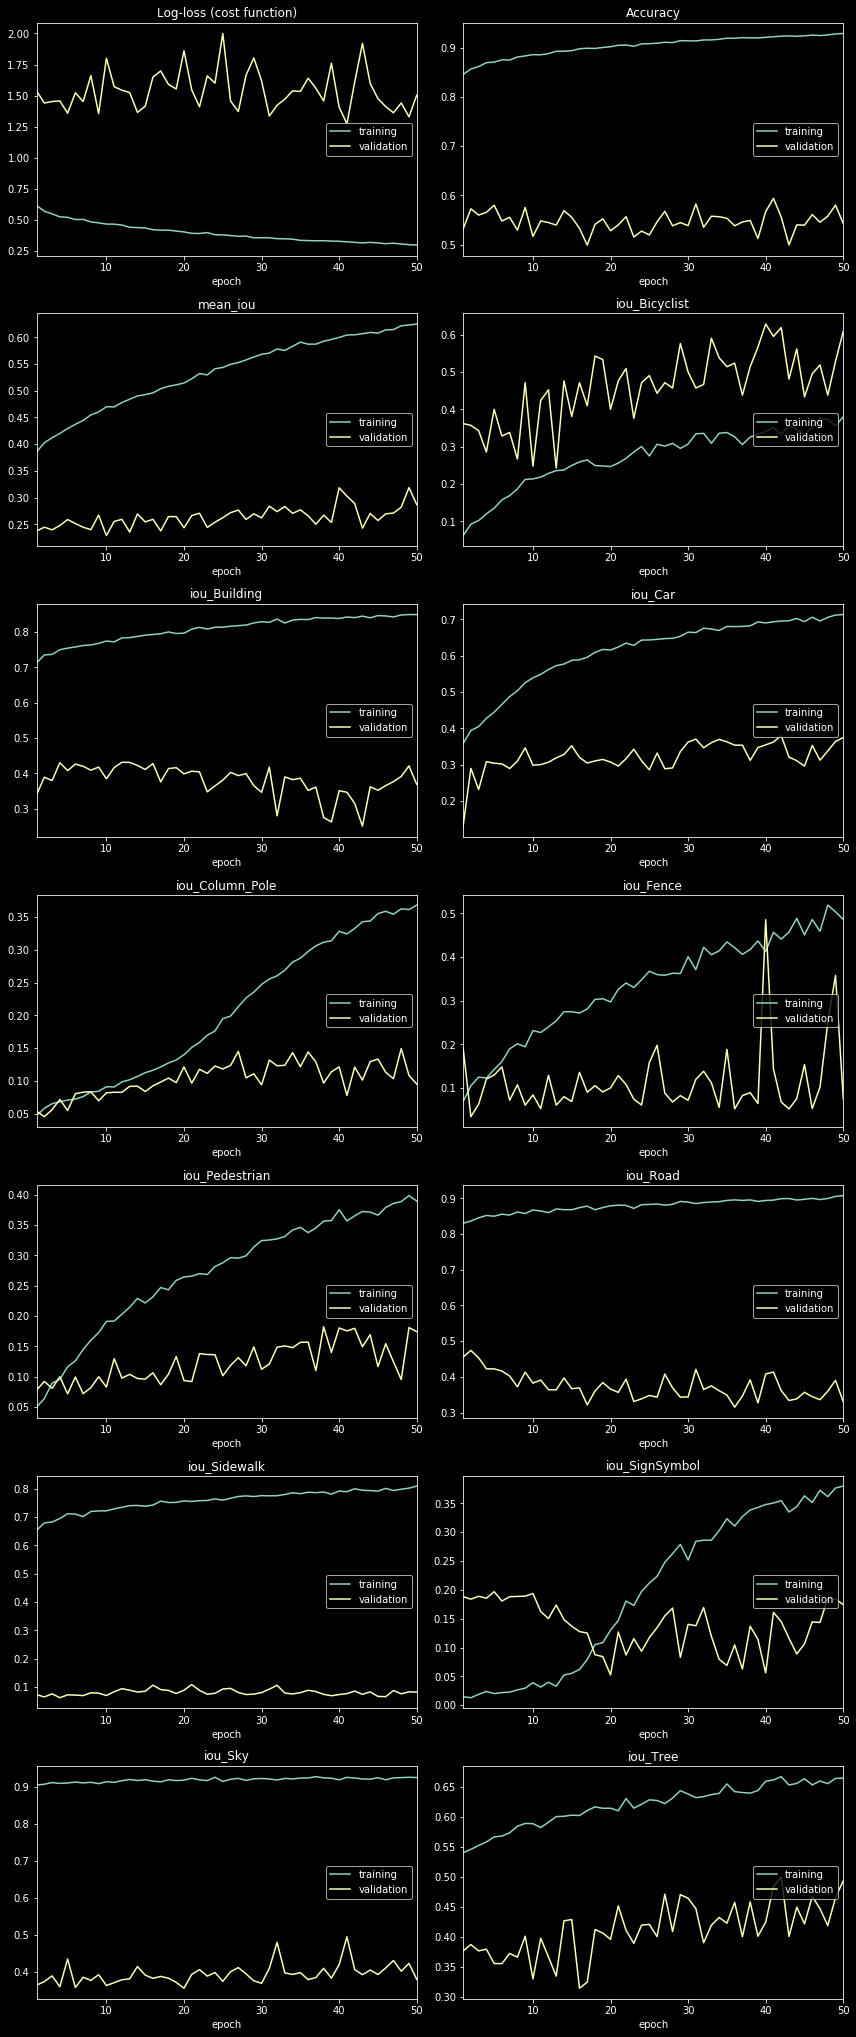

In [24]:
# fit the model with the data. use a small max queue size to 
# prevent an OOM error due to large image size
history = tune_model.fit_generator(generators['training'],
    epochs=50,
    steps_per_epoch=491,
    validation_data=generators['validation'],
    validation_steps=210,
    callbacks=[
        LearningRateScheduler(lambda _, lr: 0.995 * lr),
        EarlyStopping(monitor='val_acc', patience=50),
        PlotLossesKeras(),
    ],
    verbose=0,
    max_queue_size=1
)

In [25]:
history_to_results(history)

,train,val
acc,0.928670,0.542535
Bicyclist,0.380370,0.609524
Building,0.849298,0.368765
Car,0.713071,0.374400
Column_Pole,0.368338,0.095070
Fence,0.485890,0.074786
Pedestrian,0.389752,0.174196
Road,0.908082,0.329897
Sidewalk,0.808973,0.081746
SignSymbol,0.379764,0.174272


In [26]:
metrics = tune_model.evaluate_generator(generators['validation'], steps=210)
names = tune_model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

,val
loss,1.501969
acc,0.542201
mean_iou,0.284712
iou_Bicyclist,0.619048
iou_Building,0.367151
iou_Car,0.371873
iou_Column_Pole,0.105567
iou_Fence,0.046582
iou_Pedestrian,0.171279
iou_Road,0.318014


In [27]:
X, y = next(generators['training'])
y = camvid11.unmap(y)
p = tune_model.predict(X)
p = camvid11.unmap(p)

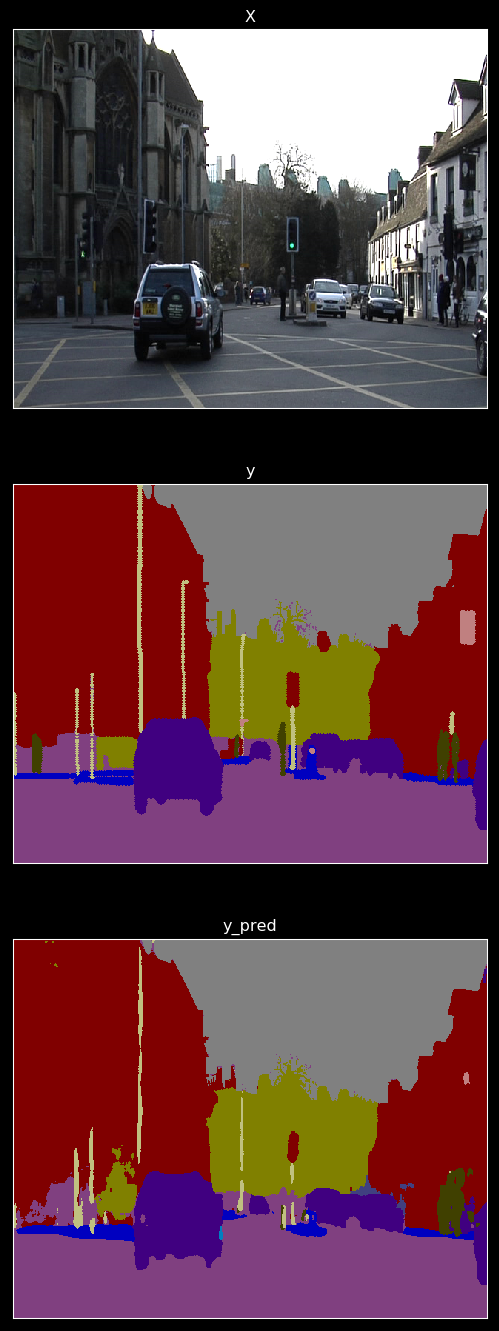

In [28]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [29]:
X, y = next(generators['validation'])
y = camvid11.unmap(y)
p = tune_model.predict(X)
p = camvid11.unmap(p)

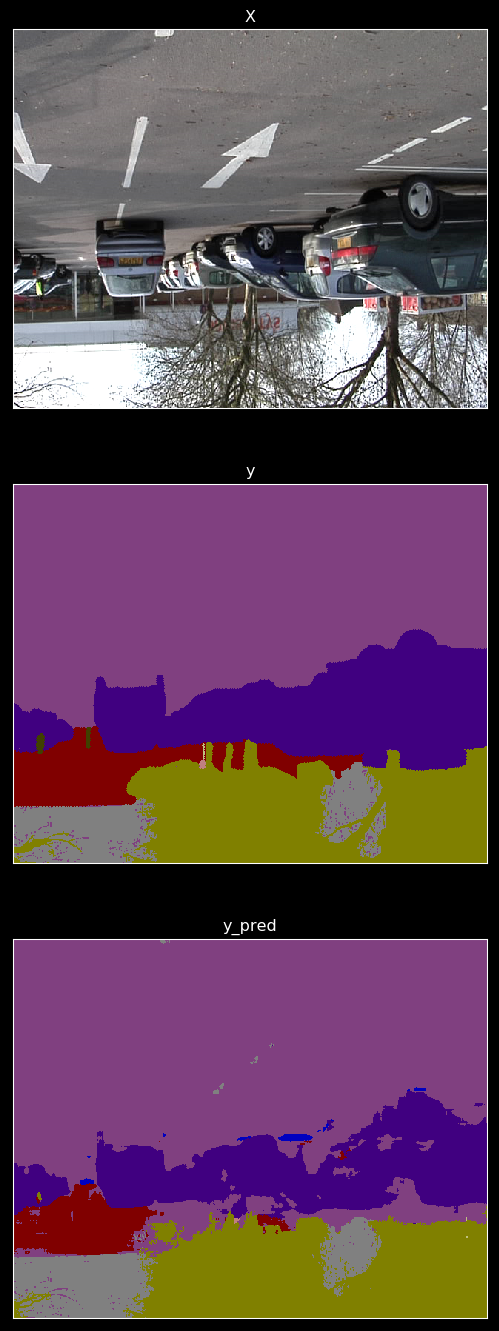

In [30]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

## Save Model

In [31]:
# serialize weights to HDF5
tune_model.save_weights('models/Tiramisu103-CamVid11-fine.h5')